In [1]:
from dabench import data, dacycler, model, obsop, observer, vector
import numpy as np
import matplotlib.pyplot as plt

/home/ksolvik/research/da/DataAssimBench/dabench/dacycler/_etkf.py:100: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (nr == self.ensemble_dim,


# Define data generator

In [13]:
# First define data generator and generate data
l96 = data.Lorenz96(system_dim=6)

In [14]:
l96.generate(n_steps=2000)

# Define model

In [15]:
l96_for_model = data.Lorenz96(system_dim=6)

class L96Model(model.Model):                                                                       
    """Defines model wrapper for Lorenz63 to test forecasting."""
    def forecast(self, state_vec):
        self.model_obj.generate(x0=state_vec.values, n_steps=2)
        new_vals = self.model_obj.values[-1]

        new_vec = vector.StateVector(values=new_vals)

        return new_vec

In [16]:
our_model = L96Model(model_obj=l96_for_model)

# Generate observations

In [22]:
# Now we can define the observer:
obs_l96 = observer.Observer(
    l96, # Data generator object
    random_time_density = 0.5, # Probability of picking each time step for random sampling
    random_location_count = 3, # Probability of picking each location in l63.system_dim for random sampling
    error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
    error_sd = 0.5, # Standard deviation for observation error, Gaussian/Normal distribution
    random_seed=94, # We can specify a random seed. Default is 99
    stationary_observers=True
)

# Making observations
obs_vec_l96 = obs_l96.observe()

# Define DA Cycler

In [26]:
dc = dacycler.ETKF(system_dim=l96.system_dim, ensemble_dim=5, delta_t=l96.delta_t, model_obj=our_model, truth_obj=l96)

# Run DA Cycler

In [27]:
cur_tstep = 1000

out_sv = dc.cycle(
    input_state = vector.StateVector(values=l96.values[cur_tstep] + np.random.normal(size=(5, 6))),
    start_time = l96.times[cur_tstep],
    obs_vector = obs_vec_l96,
    obs_time_window=0.3,
    timesteps=200)

# Plot

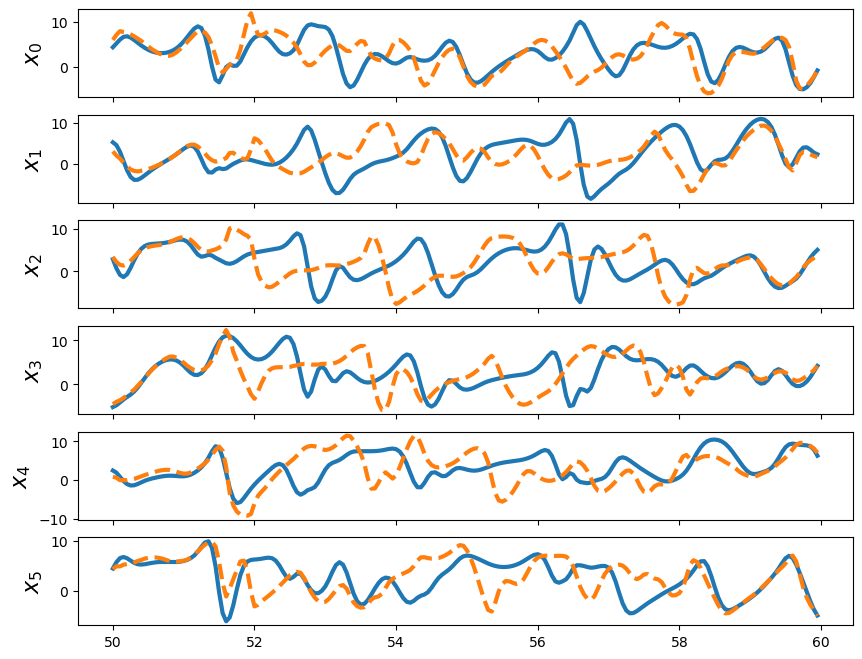

In [28]:
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(out_sv.times, l96.values[1000:1200,j], lw = 3, label = 'True')
    ax.plot(out_sv.times, np.mean(out_sv.values, axis=1)[:,j], lw = 3, ls = '--', label = 'Pred')
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)